In [10]:
# run this for all imports necessary
import torch
import torch.nn.functional as F
import torch.nn as nn
import os
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, convolve
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import normalized_root_mse as nrmse
from skimage.metrics import structural_similarity as ssm

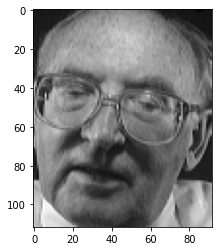

In [11]:
classes = os.listdir('./data/processed/train')
c_to_i = lambda x: classes.index(x)
i_to_c = lambda x: classes[x]

transformer = transforms.Compose([
    transforms.ToTensor(),
])

def show_img(im):
    plt.imshow(im.reshape(112, 92), cmap='gray')
    plt.show()
    
def one_hot(x):
    vec = [0] *len(classes)
    vec[x] = 1
    return vec
    
train = test= 0
train_x, train_y = ([0]) * 280, ([0]) * 280
test_x, test_y = ([0]) * 120, ([0]) * 120
asd = []

for c in os.listdir('./data/processed/train/'):
    for faces in os.listdir('./data/processed/train/'+c):
        img = np.array(Image.open('./data/processed/train/'+c+'/'+faces).convert('L'))
        train_x[train] = (img).flatten()
        train_y[train] = (c_to_i(c))
        train += 1

for c in os.listdir('./data/processed/test/'):
    for faces in os.listdir('./data/processed/test/'+c):
        img = np.array(Image.open('./data/processed/test/'+c+'/'+faces).convert('L'))
        test_x[test] = img.flatten()
        test_y[test] = (c_to_i(c))
        test += 1

train_x = np.stack([x.flatten() for x in train_x])
test_x = np.stack([x.flatten() for x in test_x])
test_y = np.array(test_y,  dtype=np.int64)
train_y = np.array(train_y, dtype=np.int64)

train_x = train_x/255
test_x = test_x/255
show_img(train_x[0])

In [12]:
def reshape_img(img):
    return np.reshape(img, (112, 92))

def add_gaussian_noise(img, var):
    mean = 0
    std = var ** 0.5
    noise = np.random.normal(mean, std, img.shape)
    img = img + noise
    return img

def add_binomial_noise(img, corruption_level):
    rand = np.random.random(img.shape)
    rand = rand >= corruption_level
    new = np.zeros(img.shape)
    new[rand] += img[rand]
    return new

In [52]:
class DAE1(torch.nn.Module):
    def __init__(self, size):
        super(DAE1, self).__init__()
        self.encode = torch.nn.Linear(size, 1000)
        self.decode = torch.nn.Linear(1000, size)
        
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        
        x = torch.tanh(self.encode(x))
        x = self.decode(x)
        return x
 
    
class DAE2(torch.nn.Module):
    def __init__(self, size):
        super(DAE2, self).__init__()
        self.encode = torch.nn.Linear(size, 300)
        self.decode = torch.nn.Linear(300, size)
        
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        
        x = torch.tanh(self.encode(x))
        x = self.decode(x)
        return x

In [36]:
# add noise for first autoencoder
lvl = 0.2
noised_imgs = []
for img in train_x:
    noised_imgs.append(add_binomial_noise(reshape_img(img), lvl))
    # noised_imgs.append(add_gaussian_noise(reshape_img(img), 0.005))

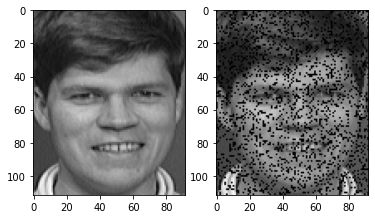

In [37]:
# evaluate noise
img_nr = 10

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(reshape_img(train_x[img_nr]), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.imshow(reshape_img(noised_imgs[img_nr]), cmap='gray')
plt.show()

In [ ]:
# train first dae with 1000 hidden nodes
model1 = DAEModel(len(train_x[0]))

steps = 1000
lr = 1e-4

#weight initialisation range??? should be -0.05 - 0.05

### tanh+linear, mse, adam, binom noise=0.2, loss=0.002190
### SGD doesn't work as well

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr) #SGD

for epoch in range(steps):
    optimizer.zero_grad()
    y_hat = model1(torch.Tensor(noised_imgs))
    loss = criterion(y_hat, torch.Tensor(train_x))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

In [39]:
output1 = model1(torch.Tensor(train_x))

In [40]:
# save first model
torch.save(model1.state_dict(), 'dae1000binom.pt')

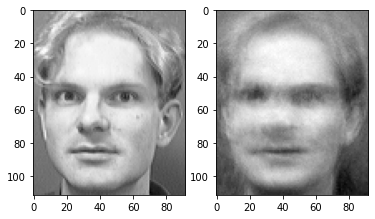

In [44]:
# evaluate reconstructed img
img_nr = 139
show = True

train_img = torch.Tensor(train_x)[img_nr].view(112,92)
rec_img = output1[img_nr].view(112,92).detach().numpy()
rec_img2 = output1[img_nr+30].view(112,92).detach().numpy()

if (show):
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(train_img, cmap='gray')

    fig.add_subplot(1,2, 2)
    plt.imshow(rec_img, cmap='gray')
    plt.show()
else:
    print(rec_img.shape)
    print(rec_img2.shape)
    print(np.equal(rec_img, rec_img2))

In [45]:
new_train_x = output1.detach().numpy()

In [46]:
# add noise for second autoencoder
lvl = 0.3
noised_imgs = []
for img in new_train_x:
    noised_imgs.append(add_binomial_noise(reshape_img(img), lvl))

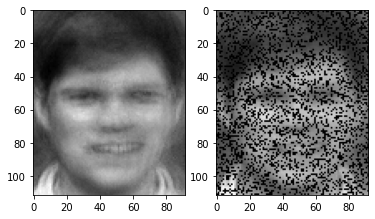

In [47]:
# evaluate noise
img_nr = 10

fig = plt.figure()
fig.add_subplot(1,2, 1)
plt.imshow(reshape_img(new_train_x[img_nr]), cmap='gray')

fig.add_subplot(1,2, 2)
plt.imshow(reshape_img(noised_imgs[img_nr]), cmap='gray')
plt.show()

In [57]:
model2 = DAE2(len(new_train_x[0]))

steps = 1000
lr = 1e-4

#weight initialisation range??? should be -0.05 - 0.05

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

for epoch in range(steps):
    optimizer.zero_grad()
    y_hat = model2(torch.Tensor(noised_imgs))
    loss = criterion(y_hat, torch.Tensor(new_train_x))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

Epoch: 0 	Training Loss: 0.039937
Epoch: 1 	Training Loss: 0.036165
Epoch: 2 	Training Loss: 0.033538
Epoch: 3 	Training Loss: 0.031654
Epoch: 4 	Training Loss: 0.030181
Epoch: 5 	Training Loss: 0.028900
Epoch: 6 	Training Loss: 0.027699
Epoch: 7 	Training Loss: 0.026540
Epoch: 8 	Training Loss: 0.025428
Epoch: 9 	Training Loss: 0.024390
Epoch: 10 	Training Loss: 0.023459
Epoch: 11 	Training Loss: 0.022658
Epoch: 12 	Training Loss: 0.021996
Epoch: 13 	Training Loss: 0.021459
Epoch: 14 	Training Loss: 0.021022
Epoch: 15 	Training Loss: 0.020655
Epoch: 16 	Training Loss: 0.020332
Epoch: 17 	Training Loss: 0.020039
Epoch: 18 	Training Loss: 0.019770
Epoch: 19 	Training Loss: 0.019526
Epoch: 20 	Training Loss: 0.019311
Epoch: 21 	Training Loss: 0.019131
Epoch: 22 	Training Loss: 0.018986
Epoch: 23 	Training Loss: 0.018872
Epoch: 24 	Training Loss: 0.018783
Epoch: 25 	Training Loss: 0.018710
Epoch: 26 	Training Loss: 0.018644
Epoch: 27 	Training Loss: 0.018578
Epoch: 28 	Training Loss: 0.01

In [65]:
output2 = model2(torch.Tensor(new_train_x))

In [66]:
# save second model
torch.save(model2.state_dict(), 'dae300.pt')

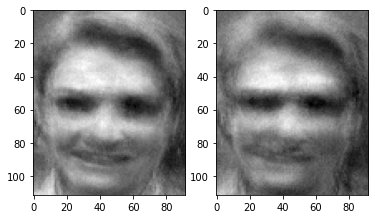

In [67]:
# evaluate reconstructed img
img_nr = 39
show = True

train_img = torch.Tensor(new_train_x)[img_nr].view(112,92)
rec_img = output2[img_nr].view(112,92).detach().numpy()
rec_img2 = output2[img_nr+30].view(112,92).detach().numpy()

if (show):
    fig = plt.figure()
    fig.add_subplot(1,2, 1)
    plt.imshow(train_img, cmap='gray')

    fig.add_subplot(1,2, 2)
    plt.imshow(rec_img, cmap='gray')
    plt.show()
else:
    print(rec_img.shape)
    print(rec_img2.shape)
    print(np.equal(rec_img, rec_img2))

In [76]:
new_new_train_x = output2.detach().numpy()

In [80]:
class SoftMaxModel(torch.nn.Module):
    def __init__(self, D_in, D_out):
        super(SoftMaxModel, self).__init__()
        
        self.linear1 = torch.nn.Linear(D_in, D_out)
        
    def forward(self,x):
        x = x.view(x.shape[0], -1)
        x = F.log_softmax(self.linear1(x), dim=1)
        return x

model3 = SoftMaxModel(len(new_new_train_x[0]), len(classes))
    
steps = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=1e-2)

for epoch in range(steps):
    optimizer.zero_grad()
    y_hat = model3(torch.Tensor(new_new_train_x))
    loss = criterion(y_hat, torch.LongTensor(train_y))
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, loss))

Epoch: 0 	Training Loss: 3.738925
Epoch: 1 	Training Loss: 3.655628
Epoch: 2 	Training Loss: 3.613644
Epoch: 3 	Training Loss: 3.577789
Epoch: 4 	Training Loss: 3.543633
Epoch: 5 	Training Loss: 3.510303
Epoch: 6 	Training Loss: 3.477619
Epoch: 7 	Training Loss: 3.445535
Epoch: 8 	Training Loss: 3.414029
Epoch: 9 	Training Loss: 3.383086
Epoch: 10 	Training Loss: 3.352688
Epoch: 11 	Training Loss: 3.322828
Epoch: 12 	Training Loss: 3.293488
Epoch: 13 	Training Loss: 3.264656
Epoch: 14 	Training Loss: 3.236319
Epoch: 15 	Training Loss: 3.208463
Epoch: 16 	Training Loss: 3.181080
Epoch: 17 	Training Loss: 3.154157
Epoch: 18 	Training Loss: 3.127680
Epoch: 19 	Training Loss: 3.101642
Epoch: 20 	Training Loss: 3.076029
Epoch: 21 	Training Loss: 3.050833
Epoch: 22 	Training Loss: 3.026041
Epoch: 23 	Training Loss: 3.001647
Epoch: 24 	Training Loss: 2.977641
Epoch: 25 	Training Loss: 2.954008
Epoch: 26 	Training Loss: 2.930747
Epoch: 27 	Training Loss: 2.907846
Epoch: 28 	Training Loss: 2.88

In [88]:
correct
for i in range(len(train_y)):
    
    if(train_y[i] == y_hat[i].argmax()):
        
#    print(f'pred: {train_y[i]} \tgt: {y_hat[i].argmax()}')
print(accArr)

[tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(False), tensor(False), tensor(False), tensor(False), tensor(False), tensor(False), tensor(True), tensor(True), tensor(True), tensor(False), tensor(False), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(False), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(True), tensor(Tru